### Download the biology text book and save it as biology_text_book.pdf, upload it to google colab before running the following code

### Extract pages from a PDF file keeping only the first two chapters

In [1]:
from pathlib import Path
from PyPDF2 import PdfReader, PdfWriter


def extract_pages(input_path: Path, start_page: int, end_page: int) -> Path:
    """
    Extract pages between start_page and end_page from a PDF file and save to a new file.

    Args:
        input_path (Path): Path to the input PDF file
        start_page (int): Starting page number (1-based indexing)
        end_page (int): Ending page number

    Returns:
        Path: Path to the output PDF file containing extracted pages
    """
    reader = PdfReader(input_path)
    writer = PdfWriter()

    # Convert 1-based page numbers to 0-based indices
    start_idx = start_page - 1
    end_idx = min(end_page, len(reader.pages))

    for page_num in range(start_idx, end_idx):
        writer.add_page(reader.pages[page_num])

    # Save the extracted pages to a new PDF file
    output_path = (
        input_path.parent / f"{input_path.stem}_pages_{start_page}_to_{end_page}.pdf"
    )
    with open(output_path, "wb") as output_file:
        writer.write(output_file)
    return output_path

In [2]:
# extract only the first two chapters from page 19 to 68
IN_PATH = Path("./biology_text_book.pdf")
DATA_IN_PATH = extract_pages(IN_PATH, start_page=19, end_page=68)

In [3]:
from haystack import Pipeline
from haystack.utils import Secret
from haystack.components.writers import DocumentWriter
from haystack.document_stores.types import DuplicatePolicy
from haystack.components.converters import PyPDFToDocument
from haystack.components.preprocessors import DocumentCleaner
from haystack.components.preprocessors import DocumentSplitter
from haystack.components.embedders import SentenceTransformersDocumentEmbedder, SentenceTransformersTextEmbedder
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.retrievers import InMemoryBM25Retriever
from haystack.components.generators.chat import HuggingFaceLocalChatGenerator

/Users/offrail/.pyenv/versions/rag/lib/python3.9/site-packages/haystack/core/errors.py:34: DeprecationWarning: PipelineMaxLoops is deprecated and will be remove in version '2.7.0'; use PipelineMaxComponentRuns instead.
  warnings.warn(
/Users/offrail/.pyenv/versions/rag/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Add your GROQ API here

In [4]:
GROQ_API_KEY = "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"

#### Uncomment to warm up hugging face local chat generator

In [5]:
# generator = HuggingFaceLocalChatGenerator(model="TinyLlama/TinyLlama-1.1B-Chat-v1.0")
# generator.warm_up()

### Ingestion Pipeline: 

Assumption: Using InMemory document store since, colab can't run docker containers

In [28]:
# ingestion pipeline components
pdf_converter = PyPDFToDocument()
document_cleaner = DocumentCleaner(remove_repeated_substrings=True)

chunk_size = 512
chunk_overlap = int(0.1 * chunk_size)
split_threshold = 0.35 * chunk_size

# Uncomment to use contextual splitter
# document_splitter = ContextualDocumentSplitter(
#     split_by="word",
#     split_length=chunk_size,
#     split_overlap=chunk_overlap,
#     split_threshold=split_threshold,
#     model="llama3-8b-8192",
# )
document_splitter = DocumentSplitter(
    split_by="word",
    split_length=chunk_size,
    split_overlap=chunk_overlap,
    split_threshold=split_threshold,
)
doc_embedder = SentenceTransformersDocumentEmbedder()

document_store = InMemoryDocumentStore()
writer = DocumentWriter(document_store, policy=DuplicatePolicy.SKIP)

# ingestion pipeline: add components
ingestion = Pipeline()
ingestion.add_component(instance=pdf_converter, name="pdf_converter")
ingestion.add_component(instance=document_cleaner, name="document_cleaner")
ingestion.add_component(instance=document_splitter, name="document_splitter")
ingestion.add_component(instance=doc_embedder, name="document_embedder")
ingestion.add_component(instance=writer, name="writer")

# ingestion pipeline: connect components
ingestion.connect("pdf_converter", "document_cleaner")
ingestion.connect("document_cleaner", "document_splitter")
ingestion.connect("document_splitter", "document_embedder")
ingestion.connect("document_embedder", "writer")

# run ingestion pipeline
ingestion.run(data={"pdf_converter": {"sources": [DATA_IN_PATH]}})

Batches: 100%|██████████| 2/2 [00:03<00:00,  1.90s/it]


{'writer': {'documents_written': 42}}

### Ingestion Pipeline architecture

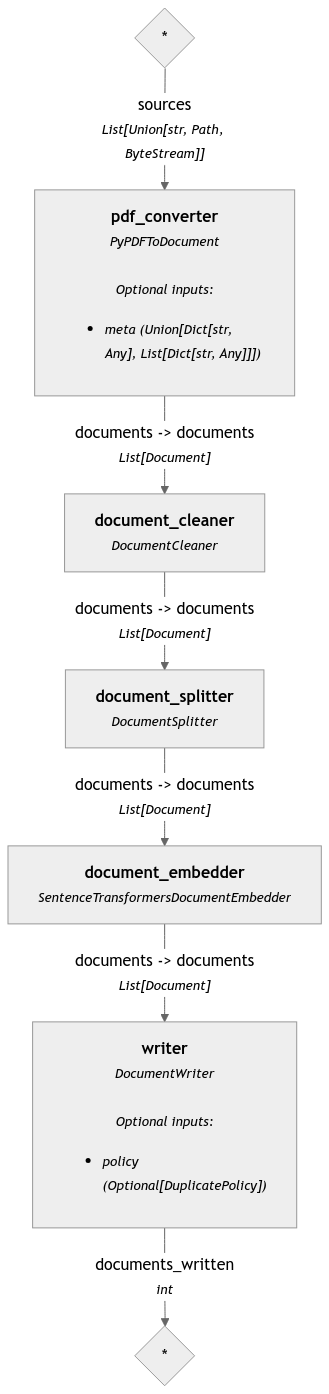

In [7]:
ingestion.show()

### Query Pipeline:

Assumption: Using InMemory document store and InMemoryBM25Retriever since, colab can't run docker containers

In [23]:
from haystack import Pipeline
from haystack.components.joiners.document_joiner import DocumentJoiner
from haystack.components.builders import PromptBuilder
from haystack.utils import Secret
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.retrievers import InMemoryBM25Retriever, InMemoryEmbeddingRetriever
from haystack.components.rankers import TransformersSimilarityRanker
from haystack.components.generators import OpenAIGenerator

# components
text_embedder = SentenceTransformersTextEmbedder()
document_store = InMemoryDocumentStore()
bm25_retriever = InMemoryBM25Retriever(document_store=document_store)
embedding_retriever = InMemoryEmbeddingRetriever(document_store=document_store)


from haystack.components.generators import HuggingFaceLocalGenerator

# Uncomment to use hugging face local chat generator
# generator = HuggingFaceLocalGenerator(model="microsoft/Phi-3-mini-4k-instruct")
# generator = HuggingFaceLocalGenerator(model="TinyLlama/TinyLlama-1.1B-Chat-v1.0")
generator = OpenAIGenerator(
    api_key=Secret.from_token(GROQ_API_KEY),
    api_base_url="https://api.groq.com/openai/v1",
    model="llama3-8b-8192",
    generation_kwargs={"max_tokens": 512},
)

template = """
Given the following information, answer the question.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{question}}
Answer:
"""
prompt_builder = PromptBuilder(template=template)

ranker = TransformersSimilarityRanker()

# query pipeline: add components
query = Pipeline()
query.add_component(
    instance=DocumentJoiner(join_mode="reciprocal_rank_fusion"), name="joiner"
)
query.add_component(instance=text_embedder, name="text_embedder")
query.add_component(instance=bm25_retriever, name="bm25_retriever")
query.add_component(instance=embedding_retriever, name="embedding_retriever")
query.add_component(instance=prompt_builder, name="prompt_builder")
query.add_component(instance=generator, name="generator")
query.add_component(instance=ranker, name="ranker")

# query pipeline: connect components
query.connect("embedding_retriever", "joiner")
query.connect("bm25_retriever", "joiner")
query.connect("text_embedder", "embedding_retriever.query_embedding")
query.connect("joiner", "ranker")
query.connect("ranker", "prompt_builder")
query.connect("prompt_builder", "generator.prompt")

🚅 Components
  - joiner: DocumentJoiner
  - text_embedder: SentenceTransformersTextEmbedder
  - bm25_retriever: InMemoryBM25Retriever
  - embedding_retriever: InMemoryEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - generator: OpenAIGenerator
  - ranker: TransformersSimilarityRanker
🛤️ Connections
  - joiner.documents -> ranker.documents (List[Document])
  - text_embedder.embedding -> embedding_retriever.query_embedding (List[float])
  - bm25_retriever.documents -> joiner.documents (List[Document])
  - embedding_retriever.documents -> joiner.documents (List[Document])
  - prompt_builder.prompt -> generator.prompt (str)
  - ranker.documents -> prompt_builder.documents (List[Document])

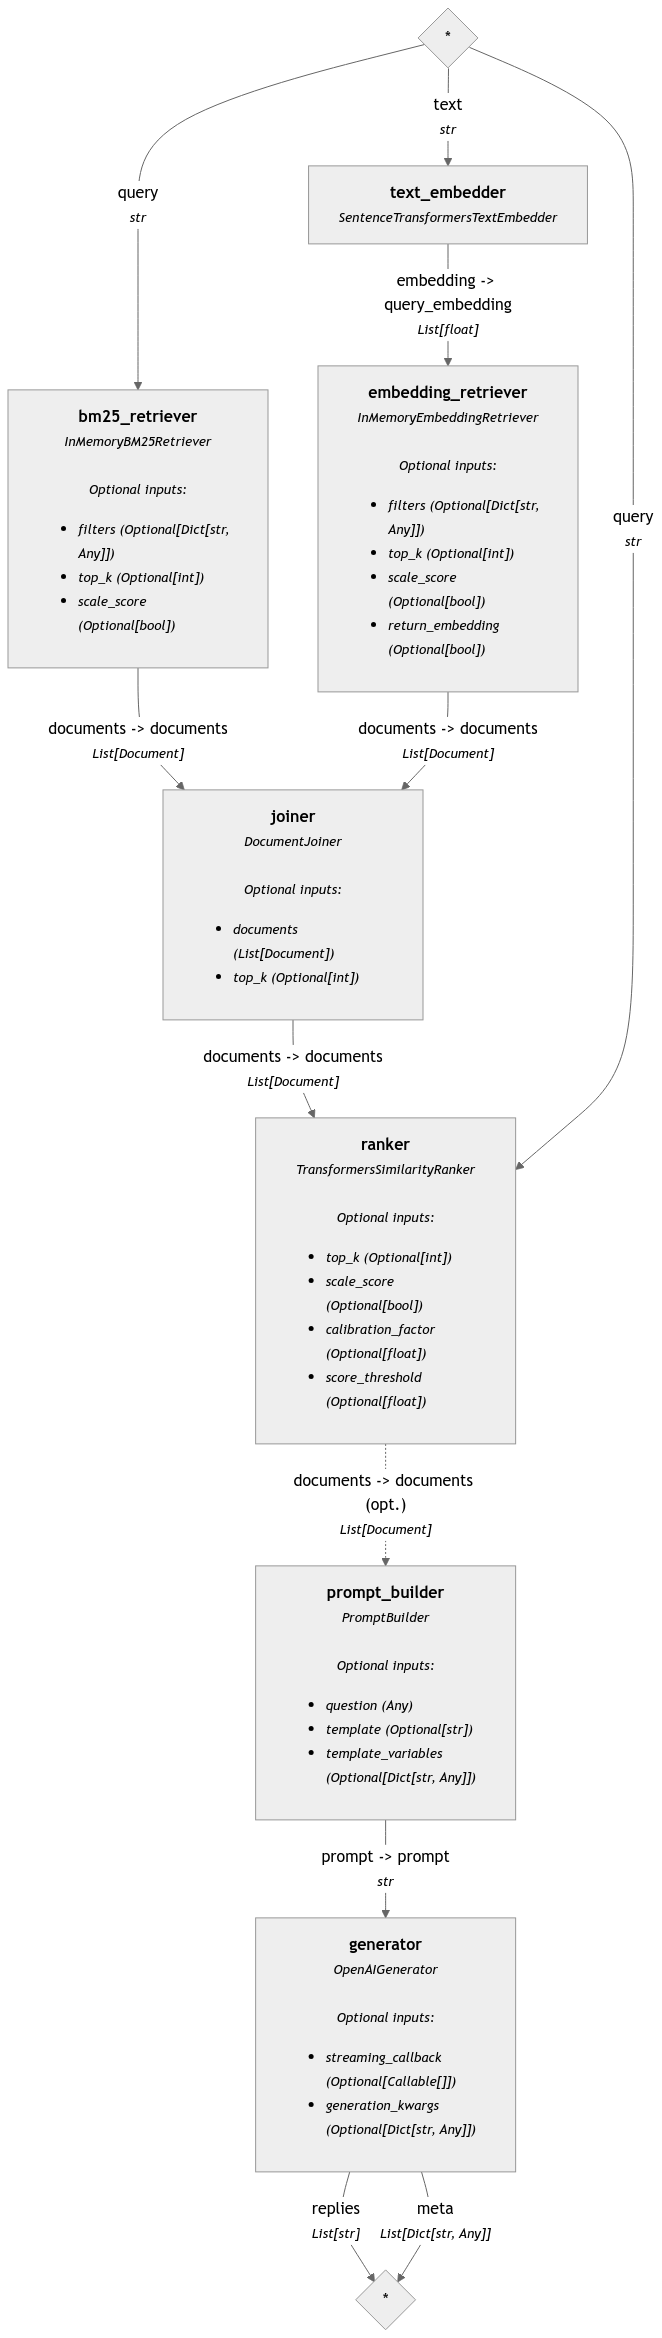

In [24]:
query.show()

In [27]:
question = "The smallest unit of biological structure that meets the functional requirements of “living” is the _______?"
result = query.run(
    data={
        "text_embedder": {"text": question},
        "prompt_builder": {"question": question},
        "embedding_retriever": {"top_k": 10},
        "bm25_retriever": {
            "query": generator.run(
                f"Extract key search terms from this text as a comma-separated list:{question}"
            )["replies"][0],
            "top_k": 10,
        },
        "ranker": {"query": question, "top_k": 5},
    }
)

# Uncomment to print the answer and the usage for local chat generator
# print(result["generator"]["replies"][0].content)
# print("-"*100)
# print(result["generator"]["replies"][0].meta["usage"])

print(result["generator"]["replies"][0])
print("-"*100)
print(result["generator"]["meta"][0]["usage"])

Batches: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]
No Documents found with embeddings. Returning empty list. To generate embeddings, use a DocumentEmbedder.


A cell is the basic structural and functional unit of living organisms.
----------------------------------------------------------------------------------------------------
{'completion_tokens': 14, 'prompt_tokens': 30, 'total_tokens': 44, 'completion_tokens_details': None, 'prompt_tokens_details': None, 'queue_time': 0.013271727, 'prompt_time': 0.001332922, 'completion_time': 0.011666667, 'total_time': 0.012999589}
